In [7]:
import tensorflow as tf
from tensorflow.keras.layers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

In [8]:
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# A brief summary of a Cyclic Generative Adversarial Network

Paper referred: https://arxiv.org/pdf/1703.10593.pdf

This notebook will give us a brief introduction of the above network. This network uses unpaired data for the purposes of training. It uses the **cycle consistency loss** to enable training without a one-to-one mapping between source and the target domain.

This opens up the possibility to do a lot of interesting tasks like photo-enhancement, image colorization, style transfer, etc. All we need is the source and the target dataset (which is directoy of images).

## Description of models:

A total of 2 Generative models and 2 Discriminator models will work in unison to make this network. 
They will utilise different loss functions for training.

**Since there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training**. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

The loss functions an their respective descriptions are stated below.

The discriminator loss and the generator loss are as follows:

In [9]:
# constant to signify the importance of how important the cyclic loss should be in the iterations
LAMBDA = 1000

# instance of BinaryCrossentropy class
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

Example of Binary cross entropy

https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy

### discriminator loss

In [10]:
# discriminator loss
def discriminator_loss(real,generated):
    '''
    Function description:
    real = the output of discriminator when real image is fed in
    generated = the output of discriminator when fake image is fed in
    
    Discriminator loss will determine whether it is able to detect real from real and fake/generated from fake/generated.
    '''
    real_loss = loss_obj(tf.ones_like(real),real)
    
    # generated image loss
    generated_loss = loss_obj(tf.zeros_like(generated),generated)
    
    # add them
    total_disc_loss = real_loss + generated_loss
    
    return total_disc_loss * 0.5

### generator loss

input: The output of the discriminator when its fed a fake/generated image.

Ideally the discriminator should be tricked by the generator into thinking that the generated images are real images.

In [11]:
# generator loss
def generator_loss(generated):
    '''
    input: output of a discriminator when supplied a generated/fake image
    
        It implies that this loss gets smaller if the discriminator marks the generated image as the real image.
        In other words this loss helps to fool the discriminator into thinking that the generated image is the real image,
        by making the generator improve by each epoch.
    '''
    return loss_obj(tf.ones_like(generated),generated)

These functions are implemented for each training epoch. 

# Input the data:

The data is taken from https://www.kaggle.com/datasets/suyashdamle/cyclegan

In [12]:
import os

In [13]:
train_aerial_path = '../maps/maps/trainA'
train_maps_path = '../maps/maps/trainB'
# Number of train images
print(len(os.listdir(train_aerial_path)))
print(len(os.listdir(train_maps_path)))

1096
1096


In [14]:

test_aerial_path = '../maps/maps/testA'
test_maps_path = '../maps/maps/testB'

print(len(os.listdir(test_aerial_path)))
print(len(os.listdir(test_maps_path)))

1098
1098


Checking the shape of the images

In [15]:
plt.imread(os.path.join(train_aerial_path,os.listdir(train_aerial_path)[0])).shape

(128, 128, 3)

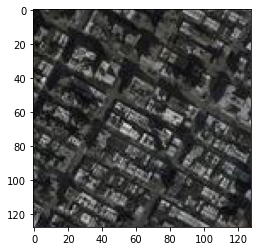

In [16]:
plt.imshow(plt.imread(os.path.join(train_aerial_path,os.listdir(train_aerial_path)[0])))

Reducing the size of the images from 600x600 to 128x128 because of GPU limit

In [17]:
from PIL import Image

In [18]:
images_path = '../maps_og/maps/maps/testB'
size = 256, 256 # (horizontal pixels, vertical pixels)
for image_name, num in zip(os.listdir(images_path), range(len(os.listdir(images_path)))):
        full_path = os.path.join(images_path, image_name)
        # changing resolution
        img = Image.open(full_path)
        resized_img = img.resize(size, Image.ANTIALIAS)
        os.remove(images_path + '/' +image_name)
        resized_img.save(images_path + '/'+str(num) + '.jpg')

In [19]:
plt.imread(os.path.join(train_aerial_path,os.listdir(train_aerial_path)[0])).shape

(128, 128, 3)

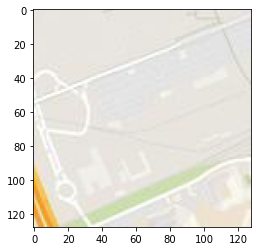

In [20]:
plt.imshow(plt.imread(os.path.join(train_maps_path,os.listdir(train_maps_path)[0])))

In [21]:
train_aerial = []
train_maps = []

# For aerial images
for image_name in os.listdir(train_aerial_path):
    full_img_name = os.path.join(train_aerial_path,image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    train_aerial.append(img_arr/255)
# For maps images
for image_name in os.listdir(train_maps_path):
    full_img_name = os.path.join(train_maps_path, image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    train_maps.append(img_arr/255)

# we can also take few images from test folder for training purposes

In [22]:
# For aerial images
for image_name in os.listdir(test_aerial_path)[:500]:
    full_img_name = os.path.join(test_aerial_path,image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    train_aerial.append(img_arr/255)
# For maps images
for image_name in os.listdir(test_maps_path)[500:1000]:
    full_img_name = os.path.join(test_maps_path, image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    train_maps.append(img_arr/255)

In [23]:
train_aerial = np.array(train_aerial, dtype='float32')
train_maps = np.array(train_maps, dtype = 'float32')
print(train_aerial.shape)
print(train_maps.shape)

(1596, 128, 128, 3)
(1596, 128, 128, 3)


Similarly for test images

In [24]:
test_aerial = []
test_maps = []

# For aerial images
for image_name in os.listdir(test_aerial_path)[500:1000]:
    full_img_name = os.path.join(test_aerial_path,image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    test_aerial.append(img_arr/255)
# For maps images
for image_name in os.listdir(test_maps_path)[:500]:
    full_img_name = os.path.join(test_maps_path, image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    test_maps.append(img_arr/255)

test_aerial = np.array(test_aerial, dtype='float32')
test_maps = np.array(test_maps, dtype = 'float32')
print(test_aerial.shape)
print(test_maps.shape)

(500, 128, 128, 3)
(500, 128, 128, 3)


Dimensions of the images:

In [25]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
CHANNELS = 3


'''Convert array into tensorFlow pipeline to easily import the data in the model'''
train_aerials = tf.data.Dataset.from_tensor_slices(train_aerial).batch(1)
train_maps = tf.data.Dataset.from_tensor_slices(train_maps).batch(1)


In [26]:
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as  K

In [27]:
# class InstanceNormalization(Layer):
#     """Instance normalization layer.
#     Normalize the activations of the previous layer at each step,
#     i.e. applies a transformation that maintains the mean activation
#     close to 0 and the activation standard deviation close to 1.
#     # Arguments
#         axis: Integer, the axis that should be normalized
#             (typically the features axis).
#             For instance, after a `Conv2D` layer with
#             `data_format="channels_first"`,
#             set `axis=1` in `InstanceNormalization`.
#             Setting `axis=None` will normalize all values in each
#             instance of the batch.
#             Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
#         epsilon: Small float added to variance to avoid dividing by zero.
#         center: If True, add offset of `beta` to normalized tensor.
#             If False, `beta` is ignored.
#         scale: If True, multiply by `gamma`.
#             If False, `gamma` is not used.
#             When the next layer is linear (also e.g. `nn.relu`),
#             this can be disabled since the scaling
#             will be done by the next layer.
#         beta_initializer: Initializer for the beta weight.
#         gamma_initializer: Initializer for the gamma weight.
#         beta_regularizer: Optional regularizer for the beta weight.
#         gamma_regularizer: Optional regularizer for the gamma weight.
#         beta_constraint: Optional constraint for the beta weight.
#         gamma_constraint: Optional constraint for the gamma weight.
#     # Input shape
#         Arbitrary. Use the keyword argument `input_shape`
#         (tuple of integers, does not include the samples axis)
#         when using this layer as the first layer in a Sequential model.
#     # Output shape
#         Same shape as input.
#     # References
#         - [Layer Normalization](https://arxiv.org/abs/1607.06450)
#         - [Instance Normalization: The Missing Ingredient for Fast Stylization](
#         https://arxiv.org/abs/1607.08022)
#     """
#     def __init__(self,
#                  axis=None,
#                  epsilon=1e-3,
#                  center=True,
#                  scale=True,
#                  beta_initializer='zeros',
#                  gamma_initializer='ones',
#                  beta_regularizer=None,
#                  gamma_regularizer=None,
#                  beta_constraint=None,
#                  gamma_constraint=None,
#                  **kwargs):
#         super(InstanceNormalization, self).__init__(**kwargs)
#         self.supports_masking = True
#         self.axis = axis
#         self.epsilon = epsilon
#         self.center = center
#         self.scale = scale
#         self.beta_initializer = initializers.get(beta_initializer)
#         self.gamma_initializer = initializers.get(gamma_initializer)
#         self.beta_regularizer = regularizers.get(beta_regularizer)
#         self.gamma_regularizer = regularizers.get(gamma_regularizer)
#         self.beta_constraint = constraints.get(beta_constraint)
#         self.gamma_constraint = constraints.get(gamma_constraint)

#     def build(self, input_shape):
#         ndim = len(input_shape)
#         if self.axis == 0:
#             raise ValueError('Axis cannot be zero')

#         if (self.axis is not None) and (ndim == 2):
#             raise ValueError('Cannot specify axis for rank 1 tensor')

#         self.input_spec = InputSpec(ndim=ndim)

#         if self.axis is None:
#             shape = (1,)
#         else:
#             shape = (input_shape[self.axis],)

#         if self.scale:
#             self.gamma = self.add_weight(shape=shape,
#                                          name='gamma',
#                                          initializer=self.gamma_initializer,
#                                          regularizer=self.gamma_regularizer,
#                                          constraint=self.gamma_constraint)
#         else:
#             self.gamma = None
#         if self.center:
#             self.beta = self.add_weight(shape=shape,
#                                         name='beta',
#                                         initializer=self.beta_initializer,
#                                         regularizer=self.beta_regularizer,
#                                         constraint=self.beta_constraint)
#         else:
#             self.beta = None
#         self.built = True

#     def call(self, inputs, training=None):
#         input_shape = K.int_shape(inputs)
#         reduction_axes = list(range(0, len(input_shape)))

#         if self.axis is not None:
#             del reduction_axes[self.axis]

#         del reduction_axes[0]

#         mean = K.mean(inputs, reduction_axes, keepdims=True)
#         stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
#         normed = (inputs - mean) / stddev

#         broadcast_shape = [1] * len(input_shape)
#         if self.axis is not None:
#             broadcast_shape[self.axis] = input_shape[self.axis]

#         if self.scale:
#             broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
#             normed = normed * broadcast_gamma
#         if self.center:
#             broadcast_beta = K.reshape(self.beta, broadcast_shape)
#             normed = normed + broadcast_beta
#         return normed

#     def get_config(self):
#         config = {
#             'axis': self.axis,
#             'epsilon': self.epsilon,
#             'center': self.center,
#             'scale': self.scale,
#             'beta_initializer': initializers.serialize(self.beta_initializer),
#             'gamma_initializer': initializers.serialize(self.gamma_initializer),
#             'beta_regularizer': regularizers.serialize(self.beta_regularizer),
#             'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
#             'beta_constraint': constraints.serialize(self.beta_constraint),
#             'gamma_constraint': constraints.serialize(self.gamma_constraint)
#         }
#         base_config = super(InstanceNormalization, self).get_config()
#         return dict(list(base_config.items()) + list(config.items()))


In [28]:
### Resnet block
def resnet_block(inp_layer,filters):
    c1 = Conv2D(filters=filters, kernel_size=3, strides=1,padding='same')(inp_layer)
    c1 = InstanceNormalization(axis=-1)(c1)
    c1 = Activation('relu')(c1)

    c2 = Conv2D(filters=filters, kernel_size=3, strides=1,padding='same')(c1)
    c2 = InstanceNormalization(axis=-1)(c2)
    c2 = concatenate([c2,inp_layer])
    return c2

In [132]:
### Resnet block class for model plotting
def resnet_block_model():
    In = Input(shape=[10,10,10])
    c1 = Conv2D(filters=4, kernel_size=3, strides=1,padding='same')(In)
    c1 = InstanceNormalization(axis=-1)(c1)
    c1 = Activation('relu')(c1)

    c2 = Conv2D(filters=4, kernel_size=3, strides=1,padding='same')(c1)
    c2 = InstanceNormalization(axis=-1)(c2)
    c2 = concatenate([c2,In])
    return tf.keras.models.Model(inputs = In,outputs=c2)

In [133]:
res = resnet_block_model()

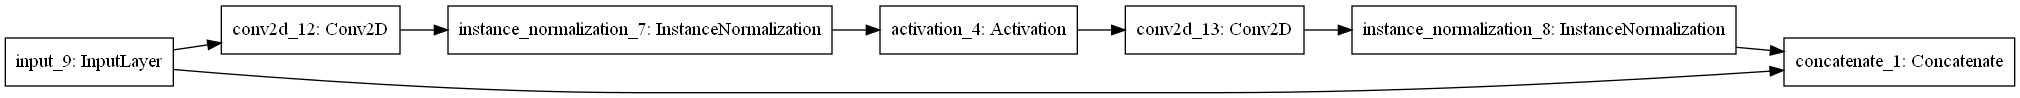

In [135]:
tf.keras.utils.plot_model(res,rankdir='LR')

## Discriminator and Generator model:

The idea of creating a U-resnet generator is from:
https://www.researchgate.net/publication/333238725_Retinal_image_synthesis_from_multiple-landmarks_input_with_generative_adversarial_networks

In [29]:
from tensorflow.keras.initializers import RandomNormal

In [142]:
def Generator():
    # weight initialization
    init = RandomNormal(stddev=0.02)
    input_layer = Input(shape=[128,128,3])
    
    # update 07062022
    #pool_layer = MaxPool2D(pool_size=(4,4),strides=1, padding='same')(input_layer)
    
    c = Conv2D(filters=64, kernel_size=7, padding='same', kernel_initializer=init)(input_layer) #(bs, 128, 128, 64)
    inst_norm = InstanceNormalization(axis=-1)(c)
    c = Activation('relu')(inst_norm)
    # Update 07062022
    #c = MaxPool2D(pool_size=(3,3),strides=1, padding='same')(c)

    c = Conv2D(128,(3,3),strides=(2,2),padding='same', kernel_initializer=init)(c)
    inst_norm = InstanceNormalization(axis=-1)(c)
    ac = Activation('relu')(inst_norm)

    c = Conv2D(256, (3,3),strides=(2,2),padding='same',kernel_initializer=init)(ac)
    inst_norm = InstanceNormalization(axis=-1)(c)
    c = Activation('relu')(inst_norm)

    #Resnet
    for i in range(6):
        c = resnet_block(c,256)

    ct = Conv2DTranspose(128, (3,3), strides=(2,2),padding='same',kernel_initializer=init)(c)
    inst_norm = InstanceNormalization(axis=-1)(ct)
    c = Activation('relu')(inst_norm)

    ct = Conv2DTranspose(64, (3,3), strides=(2,2),padding='same',kernel_initializer=init)(c)
    inst_norm = InstanceNormalization(axis=-1)(ct)
    c = Activation('relu')(inst_norm)

    last = Conv2DTranspose(filters=3,kernel_size=(7,7), padding='same',kernel_initializer=init)(c)
    inst_norm = InstanceNormalization(axis=-1)(last)
    c = Activation('tanh')(inst_norm)

    return tf.keras.models.Model(inputs = input_layer,outputs=c)


###########################################
# def Discriminator():
#     init - RandomNormal(stddev=0.02)
#     input_layer = Input(shape=[128,128,3])
#     # downsampling
#     conv1 = Conv2D(filters=64, kernel_size=7,padding='same', kernel_initializer=init)(input_layer) # (bs, 64, 64, 64)
#     a = Activation('relu')(conv1)

#     conv2 = Conv2D(filters=128,kernel_size=3, strides=2,kernel_initializer=init,padding='same')(a) #(bs, 32, 32, 128)
#     inst_norm = InstanceNormalization(axis=-1)(conv2)
#     a = Activation('relu')(inst_norm)

#     conv3 = Conv2D(filters=256,kernel_size=3, strides=2,kernel_initializer=init,padding='same')(a) #(bs, 16, 16, 256)
#     inst_norm = InstanceNormalization(axis=-1)(conv3)
#     a = Activation('relu')(inst_norm)

#     for _ in range(9):
#         a = resnet_block(a,256)
    
#     a = Conv2DTranspose(128,(3,3),strides=(2,2),padding='same', kernel_initializer=init)(a)
#     a = InstanceNormalization(axis=-1)(a)
#     a = Activation('relu')(a)

#     a = Conv2DTranspose(64,(3,3),strides=(2,2),padding='same', kernel_initializer=init)(a)
#     a = InstanceNormalization(axis=-1)(a)
#     a = Activation('relu')(a)

#     a = Conv2D(3, (7,7), padding='same', kernel_initializer=init)(a)
#     a = InstanceNormalization(axis=-1)(a)
#     last = Activation('tanh')(a)
#     return tf.keras.Model(inputs=input_layer, outputs=last)
def Discriminator():
    input_layer = Input(shape=[128,128,3])
    # downsampling
    conv1 = Conv2D(filters=64, kernel_size=4, strides=2,padding='same',activation='relu')(input_layer) # (bs, 64, 64, 64)
    
    leaky1 = LeakyReLU()(conv1)

    conv2 = Conv2D(filters=128,kernel_size=4, strides=2,activation='relu',padding='same')(leaky1) #(bs, 32, 32, 128)
    bat_norm = InstanceNormalization(axis=-1)(conv2)
    leaky2 = LeakyReLU()(bat_norm)

    conv3 = Conv2D(filters=256,kernel_size=4, strides=2,activation='relu',padding='same')(leaky2) #(bs, 16, 16, 256)
    bat_norm = InstanceNormalization(axis=-1)(conv3)
    leaky3 = LeakyReLU()(bat_norm)

    zero_pad1 = ZeroPadding2D()(leaky3)
    conv = Conv2D(filters=512, kernel_size=4, strides=1, use_bias=False)(zero_pad1)

    batch_norm = InstanceNormalization(axis=-1)(conv)

    leaky_relu = LeakyReLU()(batch_norm)

    zero_pad2 = ZeroPadding2D()(leaky_relu)

    last = Conv2D(1, 4, strides=1)(zero_pad2)

    return tf.keras.Model(inputs=input_layer, outputs=last)

We will have a look at cyclic loss and identity losses since we have already covered other losses

In [218]:
def Generator():
    # weight initialization
    init = RandomNormal(stddev=0.02)
    input_layer = Input(shape=[128,128,3])
    
    # update 07062022
    #pool_layer = MaxPool2D(pool_size=(4,4),strides=1, padding='same')(input_layer)
    
    c = Conv2D(filters=64, kernel_size=7, padding='same', kernel_initializer=init)(input_layer) #(bs, 128, 128, 64)
    inst_norm = InstanceNormalization(axis=-1)(c)
    c = Activation('relu')(inst_norm)
    # Update 07062022
    #c = MaxPool2D(pool_size=(3,3),strides=1, padding='same')(c)

    c = Conv2D(128,(3,3),strides=(2,2),padding='same', kernel_initializer=init)(c)
    inst_norm = InstanceNormalization(axis=-1)(c)
    ac = Activation('relu')(inst_norm)

    c = Conv2D(256, (3,3),strides=(2,2),padding='same',kernel_initializer=init)(ac)
    inst_norm = InstanceNormalization(axis=-1)(c)
    c = Activation('relu')(inst_norm)

    #Resnet
    for i in range(6):
        c = resnet_block(c,256)

    ct = Conv2DTranspose(128, (3,3), strides=(2,2),padding='same',kernel_initializer=init)(c)
    inst_norm = InstanceNormalization(axis=-1)(ct)
    c = Activation('relu')(inst_norm)

    ct = Conv2DTranspose(64, (3,3), strides=(2,2),padding='same',kernel_initializer=init)(c)
    inst_norm = InstanceNormalization(axis=-1)(ct)
    c = Activation('relu')(inst_norm)

    last = Conv2DTranspose(filters=3,kernel_size=(7,7), padding='same',kernel_initializer=init)(c)
    inst_norm = InstanceNormalization(axis=-1)(last)
    c = Activation('tanh')(inst_norm)

    return tf.keras.models.Model(inputs = input_layer,outputs=c)

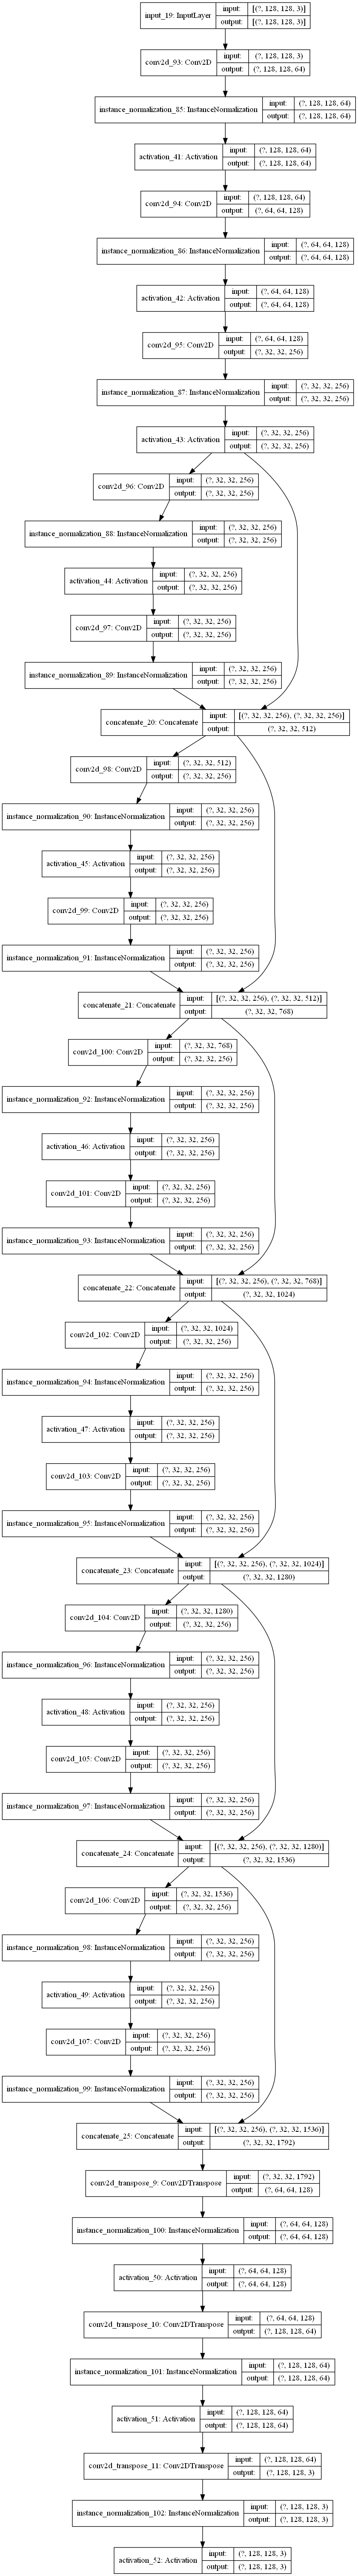

In [222]:
gen_g = Generator()
tf.keras.utils.plot_model(gen_g, show_shapes=True,, to_file='generator_architecture.png')

In [31]:
print(test_aerial[1].max())

1.0


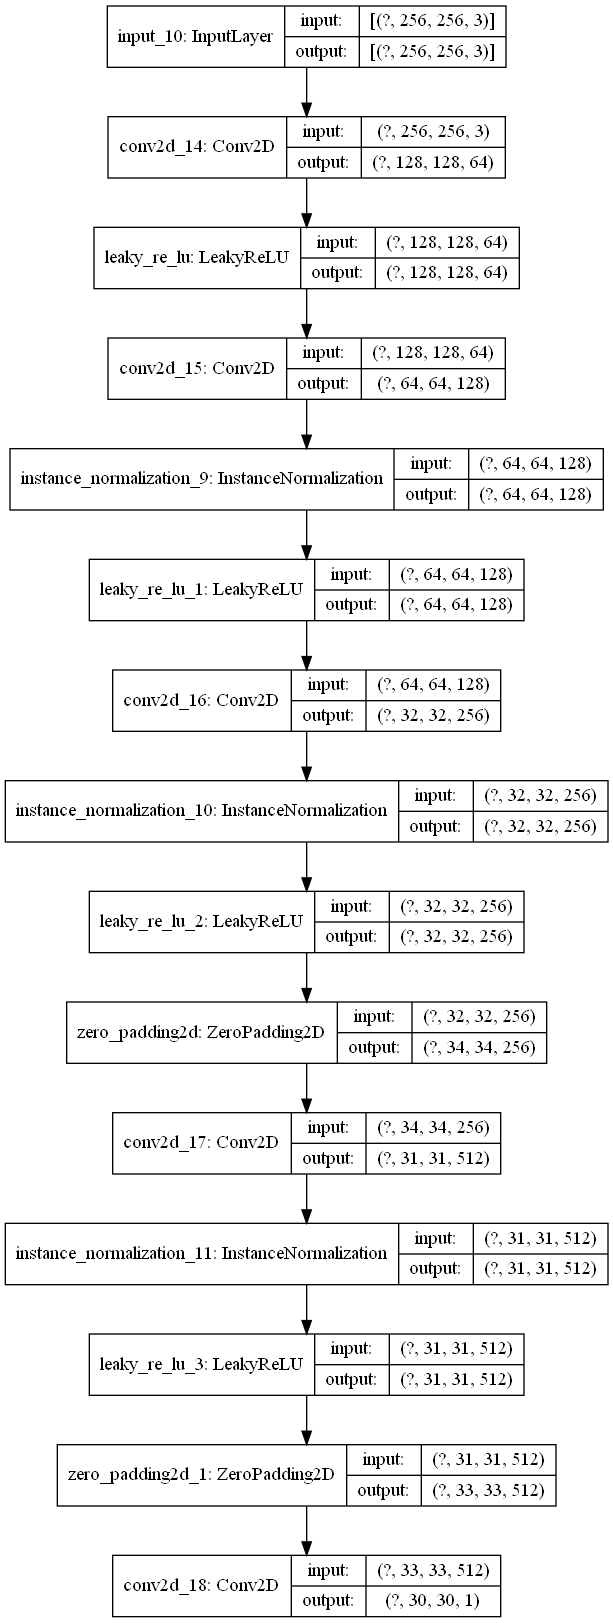

In [157]:
tf.keras.utils.plot_model(discriminator_x,show_shapes=True,to_file='discriminator_architecture.png')

# Maxpooling effect on losses:
 **update 01062022**


In [32]:
def calc_cycle_loss(real_image, cycle_image):
    # Update: 01062022 used maxplool layers for losses
    #maxpool_real = tf.keras.layers.MaxPooling2D(pool_size=(2,2),
    #                                           strides=(1,1),padding='same')(tf.reshape(real_image,(1,128,128,3)))[0] # constant image shape assumption
    #maxpool_cycled = tf.keras.layers.MaxPooling2D(pool_size=(2,2),
    #                                            strides=(1,1),padding='same')(tf.reshape(cycle_image,(1,128,128,3)))[0]

    #loss_maxpool = tf.reduce_mean(tf.abs(maxpool_real-maxpool_cycled))
    loss1 = tf.reduce_mean(tf.abs(real_image-cycle_image))
    return LAMBDA*loss1

''' generator_g is responsible for translating image X to image Y. Identity
loss says that, if you fed image Y to generator G, it should yield the real
image Y or something close to image Y.
    identity_loss = |G(Y)-Y|+|F(X)-X|'''

def identity_loss(real_image, same_image):
    # Update: 01062022 used maxplool layers for losses
    #maxpool_real = tf.keras.layers.MaxPooling2D(pool_size=(1,1),
    #                                           strides=(1,1),padding='same')(tf.reshape(real_image,(1,128,128,3)))[0]
    #maxpool_same = tf.keras.layers.MaxPooling2D(pool_size=(1,1),
    #                                           strides=(1,1), padding='same')(tf.reshape(same_image,(1,128,128,3)))[0]
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA*loss

In [33]:
test_aerial[0].reshape(1,128,128,3)

array([[[[0.28627452, 0.28627452, 0.28627452],
         [0.42745098, 0.42745098, 0.42745098],
         [0.39607844, 0.39607844, 0.3882353 ],
         ...,
         [0.41960785, 0.43137255, 0.39607844],
         [0.62352943, 0.63529414, 0.60784316],
         [0.78039217, 0.7921569 , 0.7647059 ]],

        [[0.19215687, 0.19215687, 0.19215687],
         [0.38039216, 0.38039216, 0.38039216],
         [0.45490196, 0.45490196, 0.44705883],
         ...,
         [0.31764707, 0.32941177, 0.29411766],
         [0.6039216 , 0.6156863 , 0.5882353 ],
         [0.89411765, 0.90588236, 0.8784314 ]],

        [[0.14509805, 0.14509805, 0.14509805],
         [0.39215687, 0.39215687, 0.39215687],
         [0.5294118 , 0.5294118 , 0.52156866],
         ...,
         [0.18431373, 0.19607843, 0.16078432],
         [0.43529412, 0.44705883, 0.41960785],
         [0.7647059 , 0.7764706 , 0.7490196 ]],

        ...,

        [[0.05490196, 0.06666667, 0.03921569],
         [0.16078432, 0.17254902, 0.14509805]

# Observation of maxpool outputs

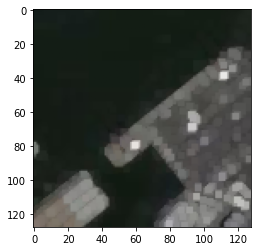

In [34]:
# plt.imshow(test_aerial[0])
plt.imshow(tf.keras.layers.MaxPooling2D(pool_size=(4,4),strides=1,padding='same')(test_aerial[40].reshape(1,128,128,3))[0])

In [35]:
tf.keras.layers.MaxPooling2D(pool_size=(4,4),strides=(1,1))(test_aerial[4].reshape(1,128,128,3))[0]

<tf.Tensor: shape=(125, 125, 3), dtype=float32, numpy=
array([[[0.5529412 , 0.53333336, 0.5176471 ],
        [0.78431374, 0.78039217, 0.7607843 ],
        [0.78431374, 0.78431374, 0.7607843 ],
        ...,
        [0.95686275, 0.95686275, 0.9490196 ],
        [0.87058824, 0.87058824, 0.8627451 ],
        [0.8039216 , 0.8039216 , 0.8039216 ]],

       [[0.4862745 , 0.48235294, 0.4627451 ],
        [0.78431374, 0.78039217, 0.7607843 ],
        [0.78431374, 0.78431374, 0.7607843 ],
        ...,
        [0.95686275, 0.95686275, 0.9490196 ],
        [0.87058824, 0.87058824, 0.8627451 ],
        [0.8039216 , 0.8039216 , 0.8039216 ]],

       [[0.4862745 , 0.48235294, 0.4627451 ],
        [0.78431374, 0.78039217, 0.7607843 ],
        [0.78431374, 0.78431374, 0.7607843 ],
        ...,
        [0.95686275, 0.95686275, 0.9490196 ],
        [0.87058824, 0.87058824, 0.8627451 ],
        [0.8039216 , 0.8039216 , 0.8039216 ]],

       ...,

       [[0.47058824, 0.46666667, 0.44705883],
        [0.52

In [36]:
tf.keras.layers.MaxPooling2D(pool_size=(4,4),strides=1,padding='same')(test_aerial[4].reshape(1,128,128,3))[0].shape

TensorShape([128, 128, 3])

## Building generator and discriminator

In [37]:
# pip install --upgrade keras==2.4.3

In [143]:
#########################################
#########################################
# Building generators and discriminators
# generator_g = Generator() # will convert aerial images to maps
# generator_f = Generator() # will convert maps to aerial images

discriminator_x = Discriminator() # checks if generated maps are fakes or real.
discriminator_y = Discriminator() # checks if generated aerial images are fakes or real. 

In [38]:
@tf.function
def train_step(real_x, real_y):
    """
    Returns 
    Cycle_loss,
    Identity Loss,
    total_loss gen g(disc + gen + cycle + identity)
    total_loss gen f
    """
    # persistent is set to True because the tape is used more than once to calculate the gradients.
    with tf.GradientTape(persistent=True) as tape:
        # Generator G translates X -> Y
        # Generator F translates Y -> X.

        fake_y = generator_g(real_x, training=True)
        cycled_x = generator_f(fake_y, training=True)

        fake_x = generator_f(real_y, training=True)
        cycled_y = generator_g(fake_x, training=True)

        # same_x and same_y are used for identity loss.
        same_x = generator_f(real_x, training=True)
        same_y = generator_g(real_y, training=True)


        disc_real_x = discriminator_x(real_x, training=True)
        disc_real_y = discriminator_y(real_y, training=True)

        disc_fake_x = discriminator_x(fake_x, training=True)
        disc_fake_y = discriminator_y(fake_y, training=True)

        # calculate the loss
        gen_g_loss = generator_loss(disc_fake_y)
        gen_f_loss = generator_loss(disc_fake_x)

        total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

        total_identity_loss = identity_loss(real_y,same_y) + identity_loss(real_x,same_x)
        # Total generator loss = adversarial loss + cycle loss
        total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
        total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

        disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
        disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
    # Calculate the gradients for generator and discriminator
    generator_g_gradients = tape.gradient(total_gen_g_loss, generator_g.trainable_variables)
    generator_f_gradients = tape.gradient(total_gen_f_loss, generator_f.trainable_variables)

    discriminator_x_gradients = tape.gradient(disc_x_loss, discriminator_x.trainable_variables)
    discriminator_y_gradients = tape.gradient(disc_y_loss, discriminator_y.trainable_variables)

    # Apply the gradients to the optimizer
    generator_g_optimizer.apply_gradients(zip(generator_g_gradients, generator_g.trainable_variables))

    generator_f_optimizer.apply_gradients(zip(generator_f_gradients, generator_f.trainable_variables))

    discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, discriminator_x.trainable_variables))

    discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, discriminator_y.trainable_variables))
    
    return total_cycle_loss, total_identity_loss,total_gen_g_loss,total_gen_f_loss

    
def generate_img(model, inp):
    op = model(inp).numpy()*0.5+0.5 #setting values from (-1,1) to (0,1)

    display_list = [inp[0], op[0]]
    title = ['input','generated']

    for i in range(2):
        plt.subplot(1, 2, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [39]:
from IPython.display import clear_output

In [40]:
# Optimizers
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)






In [41]:
type(train_aerial)

numpy.ndarray

In [42]:
EPOCHS = 200

In [43]:
tf.config.experimental_run_functions_eagerly(True)

Instructions for updating:
Use `tf.config.run_functions_eagerly` instead of the experimental version.


In [44]:
train_aerials

<BatchDataset shapes: (None, 128, 128, 3), types: tf.float32>

In [45]:
def generate_image(inp_img, a_to_m = True, test_acc = True):
    """
    Function to generate image X -> Y or Y-> X
    
    inp_img = Image array with shape (128,128,3)
    ------------
    a_to_m = "Aerial to Maps"
            True (Default): Aerial -> Maps
            False  : Maps -> Aerial
            
    test_acc: gives the output of the cyclic loss
                should be ~ 0? ideally..
                The maximum value of any pixel is 1 and the minimum is 0.
                This takes the absolute difference between each pixel value and taking the average of them
                If the pixel values are identical we get overall score of 0.
            
    Outputs:
    if a_to_m = True
    """
    fig, ax = plt.subplots(1,3,figsize=(15,5))
    if a_to_m:
        # ###### aerial to maps:
        
        # plot the given image after adding a new axis.
        ax[0].imshow(inp_img[np.newaxis,:][0])
        ax[0].set_title("Original (X)")
        
        
        ax[1].imshow(normalize(generator_g(inp_img[np.newaxis,:]).numpy())[0])
        ax[1].set_title("Generator G \n Output \n Y' = G(X)")
        
        ax[2].imshow((generator_f(generator_g(inp_img[np.newaxis,:])))[0])
        ax[2].set_title("Cycled: \n X' = F(Y')")
        
        # Output the test accuracy too
        cycled_loss = tf.reduce_mean(abs(inp_img[np.newaxis,:][0]-generator_f(generator_g(inp_img[np.newaxis,:]))[0]))
        identity_loss = tf.reduce_mean(abs(inp_img[np.newaxis,:][0] - generator_f(inp_img[np.newaxis,:])[0]))
        avg_loss = (cycled_loss+identity_loss)/2
        print(f"average of cycle and identity loss = {avg_loss}\n Accuracy = 1 - avg_loss = {1-avg_loss}")
        
        
    else:
        # ###### maps to aerial:
            
        # plot the given image after adding a new axis.
        ax[0].imshow(inp_img[np.newaxis,:][0])
        ax[0].set_title("Original (Y)")
        
        ax[1].imshow(generator_f(inp_img[np.newaxis,:])[0])
        ax[1].set_title("Generator F \n Output \n X' = F(Y)" )
        
        ax[2].imshow(generator_g(generator_f(inp_img[np.newaxis,:]))[0])
        ax[2].set_title("Cycled \n Y' =  F(X')")
        
        # Output the test accuracy here as well
        cycled_loss = tf.reduce_mean(abs(inp_img[np.newaxis,:][0]-generator_g(generator_f(inp_img[np.newaxis,:]))[0]))
        identity_loss = tf.reduce_mean(abs(inp_img[np.newaxis,:][0] - generator_g(inp_img[np.newaxis,:])[0]))
        avg_loss = (cycled_loss+identity_loss)/2
        print(f"average of cycle and identity loss = {avg_loss}\n Accuracy = 1 - avg_loss = {1-avg_loss}")
    plt.show()

In [46]:
def normalize(img_arr):
    return (img_arr - img_arr.min()) / (img_arr.max() - img_arr.min())

In [177]:
# total cyclic loss for each epoch
total_cyc = []
total_identity = []
total_gen_g = []
total_gen_f = []

In [43]:
for epoch in range(EPOCHS):
    start = time.time()

    n = 0
    tc, ti, tg, t_f = 0,0,0,0
    for en_image_x, en_image_y in tf.data.Dataset.zip((train_aerials, train_maps)):

        l1, l2,l3,l4 =  train_step(en_image_x, en_image_y)
        
        tc+= l1
        ti+= l2
        tg+=l3
        t_f+=l4
        if n % 10 == 0:
            print ('.', end='')
            random_img = train_aerial[40]
            #generate_img(generator_g,random_img.reshape((1,)+random_img.shape[:]))
            generate_image(inp_img=random_img,a_to_m=True)
        n+=1
    clear_output(wait=True)
    
    # update the list and add the average losses:
    total_cyc.append(tc/len(train_aerials))
    total_identity.append(ti/len(train_aerials))
    total_gen_g.append(tg/len(train_aerials))
    total_gen_f.append(t_f/len(train_aerials))
    #Random image:
    rnd = np.random.randint(0, len(train_aerial))
    random_img = train_aerial[rnd]
    #generate_img(generator_g,random_img.reshape((1,)+random_img.shape[:]))
    generate_image(inp_img=random_img,a_to_m=True)
    if (epoch + 1) % 5 == 0:
        # save the model:
        generator_g.save('generator_g_with_maxpool_update2.h5',overwrite=True)
        generator_f.save('generator_f_with_maxpool_update2.h5',overwrite=True)
        discriminator_x.save('discriminator_x_with_maxpool_update2.h5',overwrite=True)
        discriminator_y.save('discriminator_y_with_maxpool_update2.h5',overwrite=True)
        print('Model saved')

    print(f'Time taken for epoch {epoch + 1} is {time.time() - start}')


ResourceExhaustedError: OOM when allocating tensor with shape[2,1536,32,32] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2DBackpropFilter]

In [38]:
# %tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
1.281416500000006
GPU (s):
0.13338219999999978
GPU speedup over CPU: 9x


Old

In [137]:
discriminator

NameError: name 'discriminator' is not defined

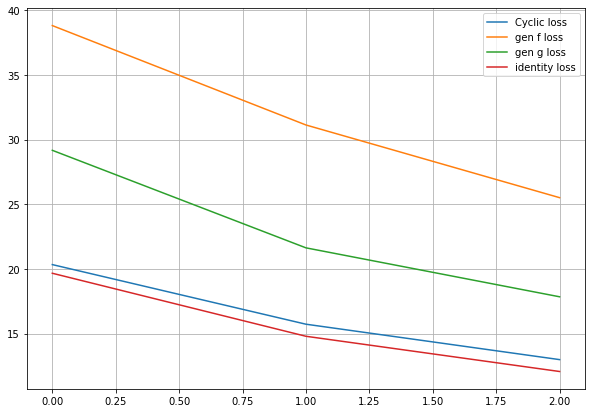

In [46]:
plt.figure(figsize=(10,7))
plt.plot(total_cyc,label='Cyclic loss')
plt.plot(total_gen_f, label='gen f loss')
plt.plot(total_gen_g, label = 'gen g loss')
plt.plot(total_identity, label = 'identity loss')
plt.grid()
plt.legend()
plt.show()

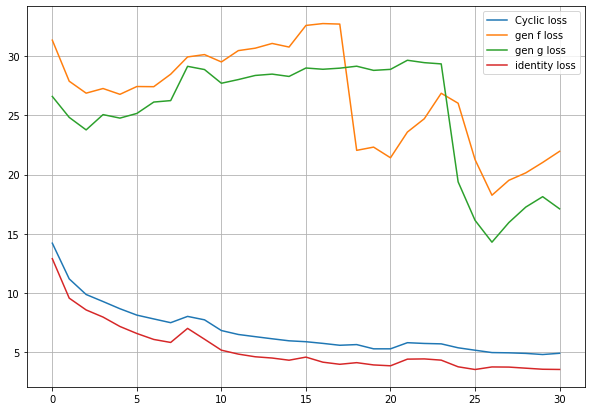

In [42]:
plt.figure(figsize=(10,7))
plt.plot(total_cyc,label='Cyclic loss')
plt.plot(total_gen_f, label='gen f loss')
plt.plot(total_gen_g, label = 'gen g loss')
plt.plot(total_identity, label = 'identity loss')
plt.grid()
plt.legend()
plt.show()

In [89]:
generator_g.save('generator_g_better5.h5',overwrite=True)
generator_f.save('generator_f_better5.h5',overwrite=True)
discriminator_x.save('discriminator_x_better5.h5',overwrite=True)
discriminator_y.save('discriminator_y_better5.h5',overwrite=True)

In [124]:
def nice():
    return 1,2,3,4

p,q,r,s += nice()

TypeError: bad operand type for unary +: 'tuple'

# Loading Models

Side note: generator_g_better5 performs the best.

In [158]:
# recalling the models

generator_g = tf.keras.models.load_model('C:/Users/astro/Downloads/generator_g_128px_L1000_epoch95.h5',
                                         custom_objects={'InstanceNormalization':InstanceNormalization})

#### generator_f_better.h5 works better than generator_f_better2.h5 i guess
generator_f = tf.keras.models.load_model('C:/Users/astro/Downloads/generator_f_128px_L1000_epoch95.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

discriminator_x = tf.keras.models.load_model('C:/Users/astro/Downloads/discriminator_x_128px_L1000_epoch95.h5',custom_objects={'InstanceNormalization':InstanceNormalization})
discriminator_y = tf.keras.models.load_model('C:/Users/astro/Downloads/discriminator_x_128px_L1000_epoch95.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

In [ ]:
tf.keras.layers.LeakyReLU()

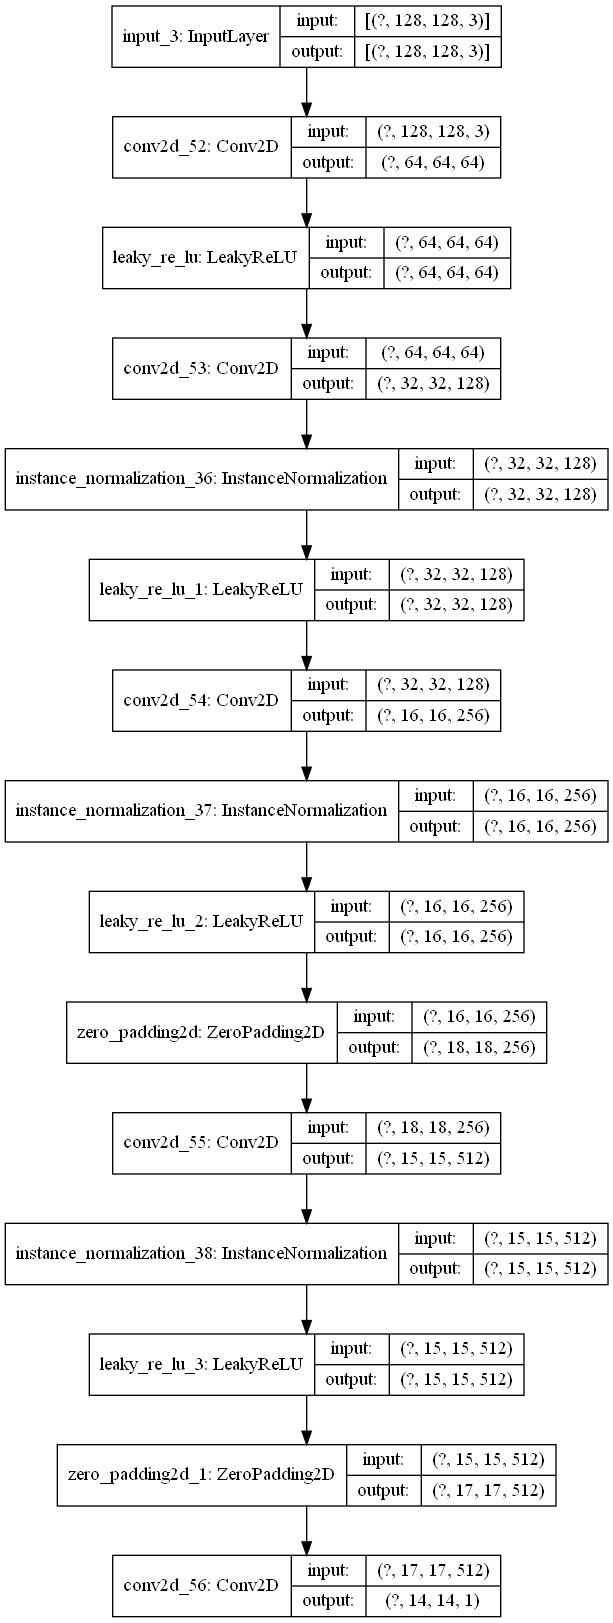

In [160]:
tf.keras.utils.plot_model(discriminator_x,show_shapes=True,to_file='discriminator_architecture.png')

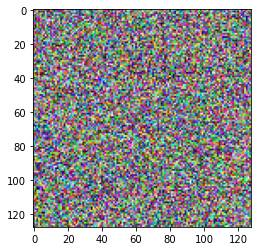

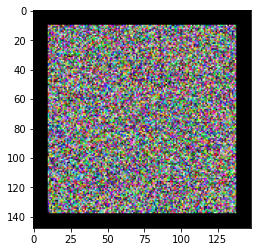

In [217]:
# Random Image of shape 128x128 pixels with 3 color channels
r_image = np.random.randint(0,255,size=(1,128,128,3))
plt.imshow(r_image[0,:,:,:])
plt.show()
plt.imshow(tf.keras.layers.ZeroPadding2D(padding=(10,10))(r_image).numpy()[0,:,:,:])
plt.show()
# print(r_image.shape)

In [215]:
padded_image = tf.keras.layers.ZeroPadding2D(padding=(10,10))(r_image).numpy()
print(padded_image.shape)

(1, 148, 148, 3)


In [151]:
# define the discriminator model
def define_discriminator(image_shape):
	# weight initialization
	init = RandomNormal(stddev=0.02)
	# source image input
	in_image = Input(shape=image_shape)
	# C64
	d = Conv2D(64, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(in_image)
	d = LeakyReLU(alpha=0.2)(d)
	# C128
	d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C256
	d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# C512
	d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# second last output layer
	d = Conv2D(512, (4,4), padding='same', kernel_initializer=init)(d)
	d = InstanceNormalization(axis=-1)(d)
	d = LeakyReLU(alpha=0.2)(d)
	# patch output
	patch_out = Conv2D(1, (4,4), padding='same', kernel_initializer=init)(d)
	# define model
	model = tf.keras.models.Model(in_image, patch_out)
	# compile model
	model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(lr=0.0002, beta_1=0.5), loss_weights=[0.5])
	return model

In [152]:
disc_X = define_discriminator([256,256,3])

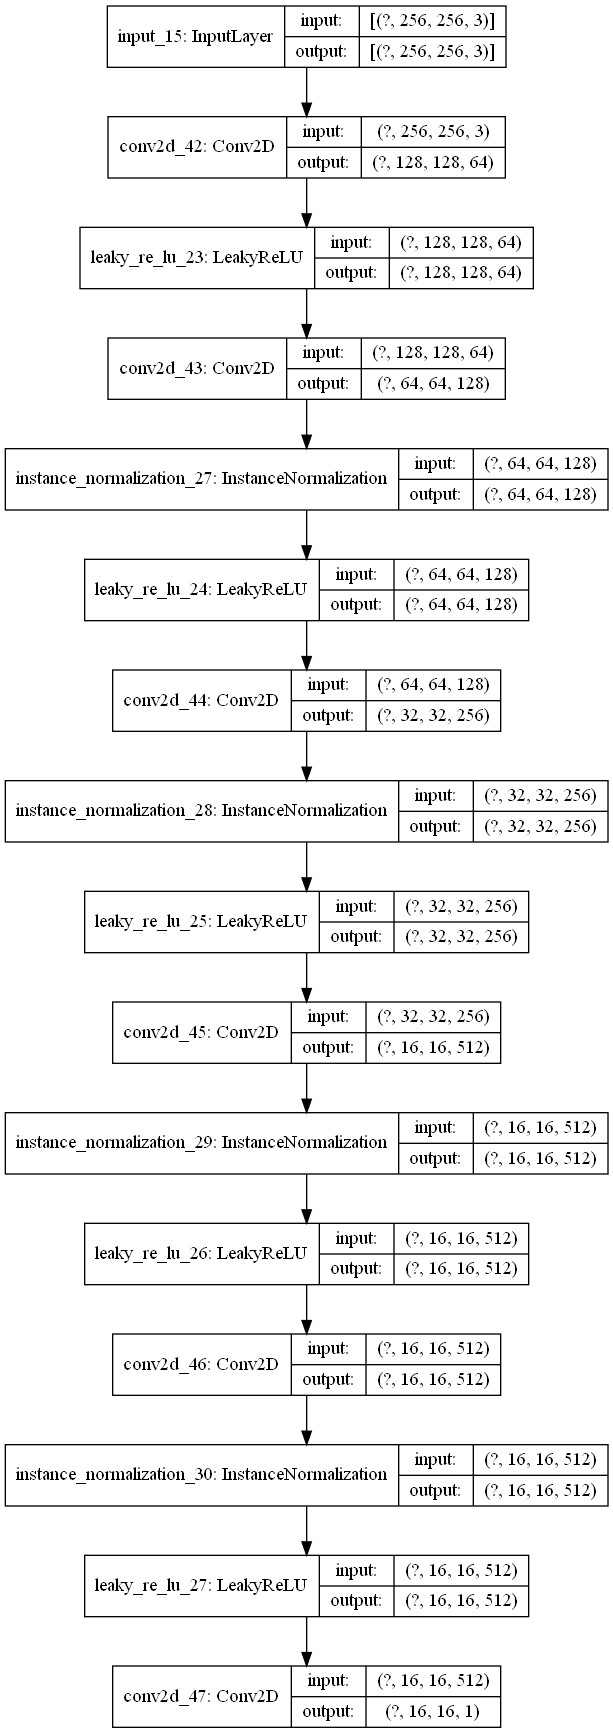

In [154]:
tf.keras.utils.plot_model(disc_X,show_shapes=True)

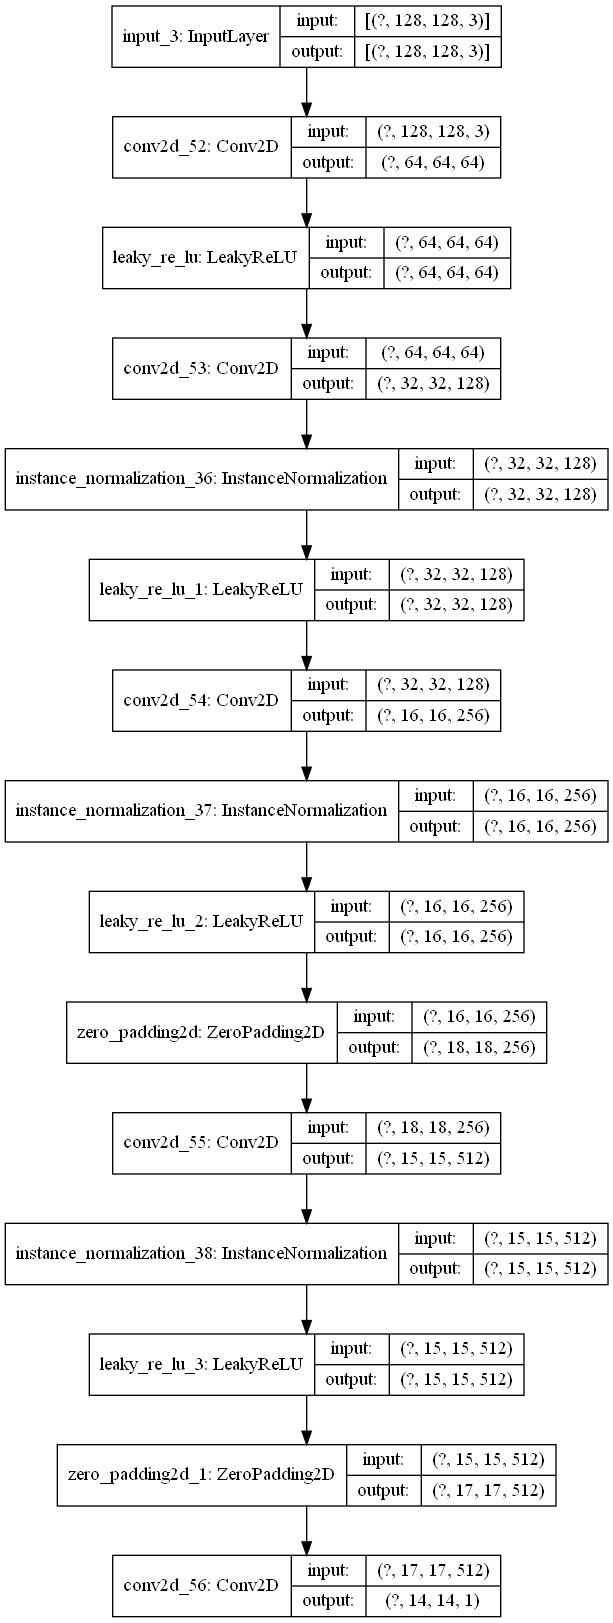

In [141]:
tf.keras.utils.plot_model(discriminator_x,show_shapes=True)

### Making functions to generate aerial images from maps, vice versa

In [48]:
test_aerial[1].shape

(128, 128, 3)

# Previously Trained models evaluations:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


average of cycle and identity loss = 0.044102899730205536
 Accuracy = 1 - avg_loss = 0.9558970928192139


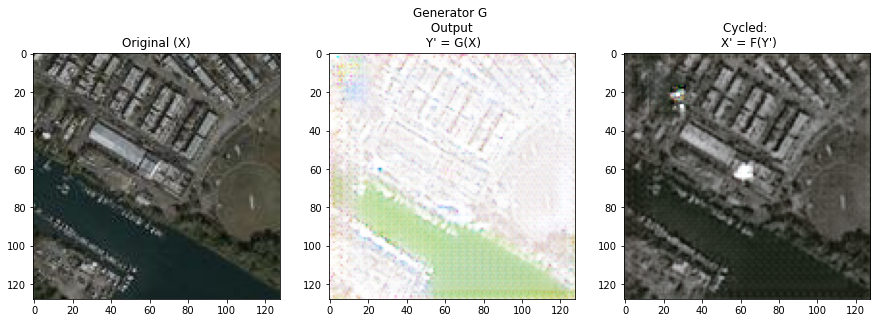

In [65]:
generate_image(test_aerial[130],a_to_m=True)

In [66]:
# recalling the models

generator_g = tf.keras.models.load_model('C:/Users/astro/Downloads/generator_g_with_maxpool_update2 (2).h5',
                                         custom_objects={'InstanceNormalization':InstanceNormalization})

#### generator_f_better.h5 works better than generator_f_better2.h5 i guess
generator_f = tf.keras.models.load_model('C:/Users/astro/Downloads/generator_f_with_maxpool_update2 (2).h5',custom_objects={'InstanceNormalization':InstanceNormalization})

# discriminator_x = tf.keras.models.load_model('discriminator_x_better2.h5',custom_objects={'InstanceNormalization':InstanceNormalization})
# discriminator_y = tf.keras.models.load_model('discriminator_y_better2.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


average of cycle and identity loss = 0.0244702510535717
 Accuracy = 1 - avg_loss = 0.9755297303199768


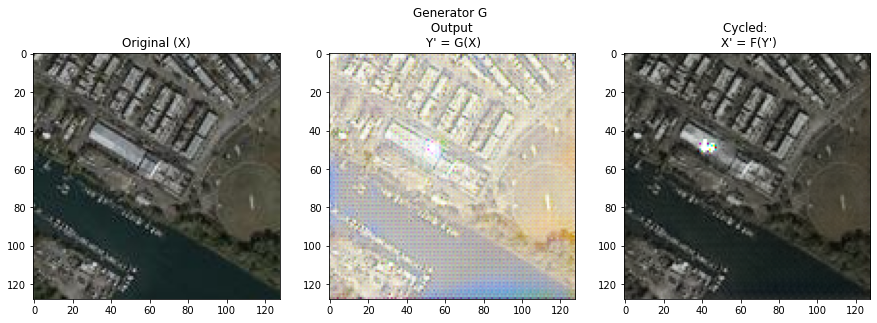

In [67]:
generate_image(test_aerial[130],a_to_m=True)

In [70]:
# recalling the models

generator_g = tf.keras.models.load_model('C:/Users/astro/Downloads/generator_g_with_maxpool_update2.h5',
                                         custom_objects={'InstanceNormalization':InstanceNormalization})

#### generator_f_better.h5 works better than generator_f_better2.h5 i guess
generator_f = tf.keras.models.load_model('C:/Users/astro/Downloads/generator_f_with_maxpool_update2.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

# discriminator_x = tf.keras.models.load_model('discriminator_x_better2.h5',custom_objects={'InstanceNormalization':InstanceNormalization})
# discriminator_y = tf.keras.models.load_model('discriminator_y_better2.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


average of cycle and identity loss = 0.05383894592523575
 Accuracy = 1 - avg_loss = 0.9461610317230225


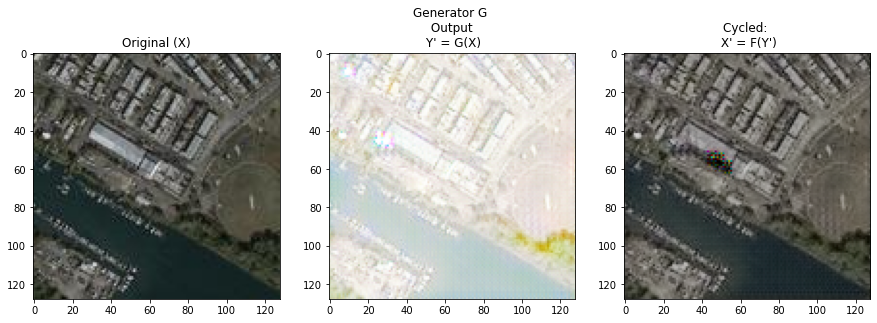

In [71]:
generate_image(test_aerial[130],a_to_m=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


average of cycle and identity loss = 0.05603555962443352
 Accuracy = 1 - avg_loss = 0.943964421749115


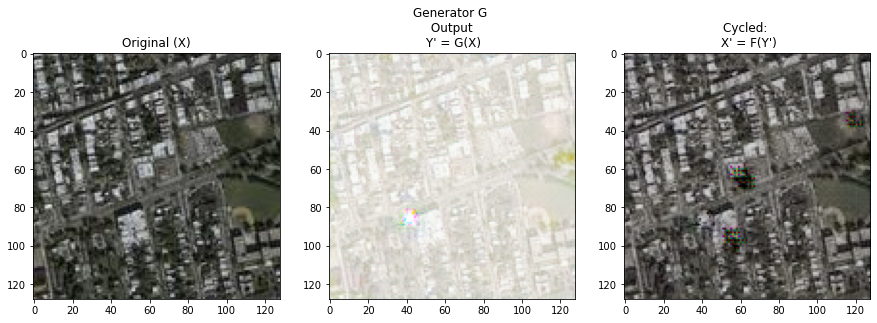

average of cycle and identity loss = 0.07020898908376694
 Accuracy = 1 - avg_loss = 0.9297910332679749


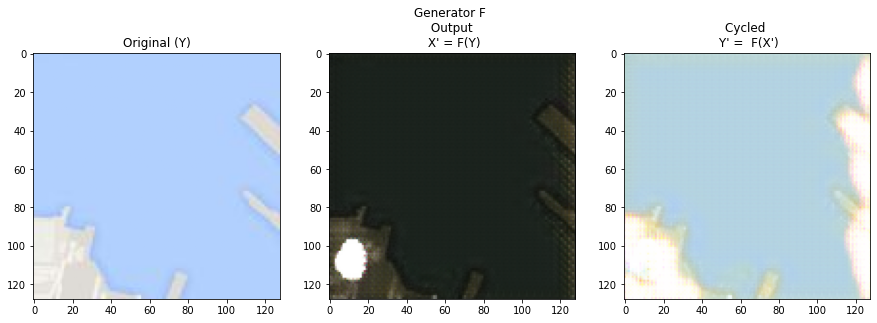

In [72]:
generate_image(test_aerial[69],a_to_m=True)
generate_image(test_maps[431],a_to_m=False)

In [43]:
generate_image(normalize(test_aerial[169]),a_to_m=True)
generate_image(test_maps[43],a_to_m=False)

NameError: name 'normalize' is not defined

In [75]:
# images_path = './Final project/maps/maps/testB'
# size = 128, 128 # (horizontal pixels, vertical pixels)
# for image_name, num in zip(os.listdir(images_path), range(len(os.listdir(images_path)))):
#         full_path = os.path.join(images_path, image_name)
#         # changing resolution
#         img = Image.open(full_path)
#         resized_img = img.resize(size, Image.ANTIALIAS)
#         os.remove(images_path + '/' +image_name)
#         resized_img.save(images_path + '/'+str(num) + '.jpg')

def convert_img(path):
    """
    Converts the given image_path to a generator friendly array
    returns image array"""
    size = (128,128)
    img = Image.open(path)
    resized_img = img.resize(size,Image.ANTIALIAS)
    return np.array(resized_img)[:,:,:3]

In [76]:
maynooth_sat = convert_img(path="C:/Users/astro/Documents/MASTER'S Courses/Maynooth uni/Courses/SEM_2/Final project/Aerial-images-to-maps/Screenshot (139).png")

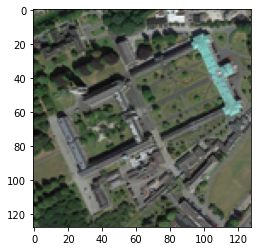

In [77]:
plt.imshow(maynooth_sat)

In [ ]:
generator_g()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


average of cycle and identity loss = 0.5706394910812378
 Accuracy = 1 - avg_loss = 0.4293605089187622


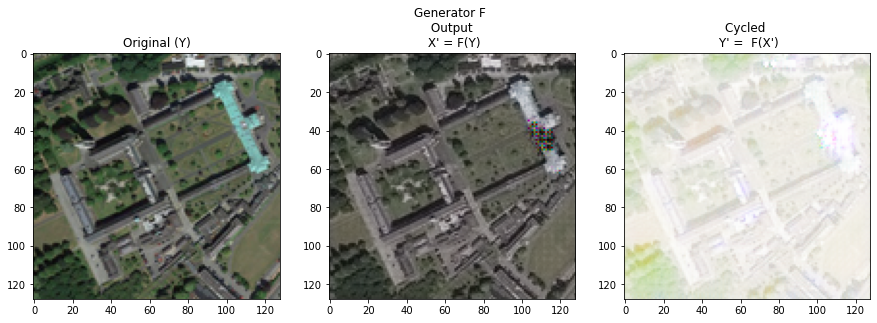

In [78]:
generate_image(normalize(maynooth_sat),a_to_m=False)

# Maynooth map

In [79]:
maynooth_map = convert_img("C:/Users/astro/Documents/MASTER'S Courses/Maynooth uni/Courses/SEM_2/Final project/Aerial-images-to-maps/maynooth map.png")

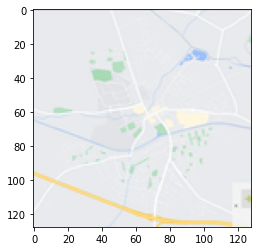

In [80]:
plt.imshow(maynooth_map)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


average of cycle and identity loss = 0.5415093898773193
 Accuracy = 1 - avg_loss = 0.45849061012268066


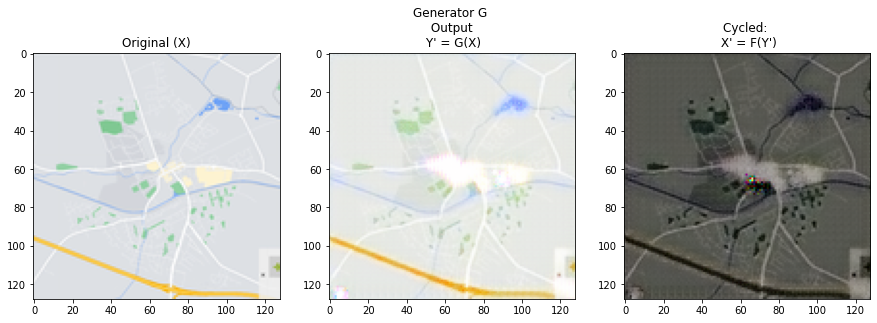

In [82]:
generate_image(normalize(maynooth_map),a_to_m=True)

# Dublin map

In [83]:
dublin_map = convert_img("C:/Users/astro/Documents/MASTER'S Courses/Maynooth uni/Courses/SEM_2/Final project/Aerial-images-to-maps/dublin map.png")

In [84]:
def normalize(img_arr):
    return (img_arr - img_arr.min()) / (img_arr.max() - img_arr.min())

In [85]:
normalize(dublin_map)

array([[[0.61805556, 0.83333333, 0.67361111],
        [0.53472222, 0.80555556, 0.60416667],
        [0.50694444, 0.77777778, 0.625     ],
        ...,
        [0.3125    , 0.5625    , 0.95833333],
        [0.3125    , 0.5625    , 0.95833333],
        [0.3125    , 0.5625    , 0.95833333]],

       [[0.51388889, 0.79166667, 0.59027778],
        [0.52777778, 0.79861111, 0.59722222],
        [0.50694444, 0.77777778, 0.625     ],
        ...,
        [0.3125    , 0.5625    , 0.95833333],
        [0.3125    , 0.5625    , 0.95833333],
        [0.3125    , 0.5625    , 0.95833333]],

       [[0.53472222, 0.79861111, 0.60416667],
        [0.50694444, 0.79166667, 0.59722222],
        [0.61111111, 0.82638889, 0.70138889],
        ...,
        [0.3125    , 0.5625    , 0.95833333],
        [0.3125    , 0.5625    , 0.95833333],
        [0.3125    , 0.5625    , 0.95833333]],

       ...,

       [[0.52777778, 0.80555556, 0.625     ],
        [0.54166667, 0.79861111, 0.61111111],
        [0.52777778, 0

In [86]:
generator_g(dublin_map.reshape(1,128,128,3)).numpy().min()

-0.19844414

In [89]:
# recalling the models

generator_g = tf.keras.models.load_model('C:/Users/astro/Downloads/generator_g_128px_L1000_epoch95.h5',
                                         custom_objects={'InstanceNormalization':InstanceNormalization})

#### generator_f_better.h5 works better than generator_f_better2.h5 i guess
generator_f = tf.keras.models.load_model('C:/Users/astro/Downloads/generator_f_128px_L1000_epoch95.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

# discriminator_x = tf.keras.models.load_model('discriminator_x_better2.h5',custom_objects={'InstanceNormalization':InstanceNormalization})
# discriminator_y = tf.keras.models.load_model('discriminator_y_better2.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

average of cycle and identity loss = 0.16112735867500305
 Accuracy = 1 - avg_loss = 0.8388726711273193


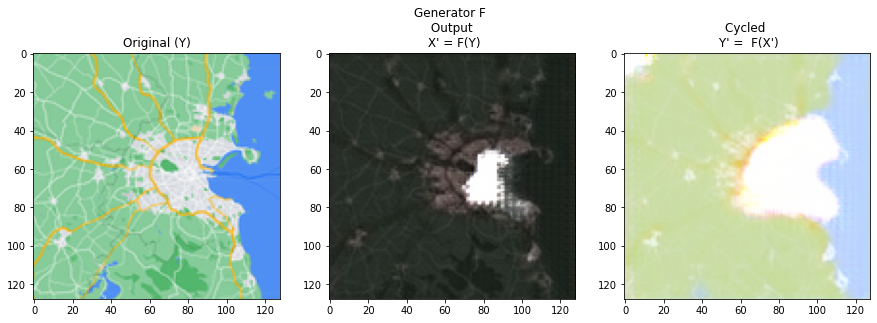

In [91]:
generate_image(normalize(dublin_map),a_to_m=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


average of cycle and identity loss = 0.12292701005935669
 Accuracy = 1 - avg_loss = 0.8770729899406433


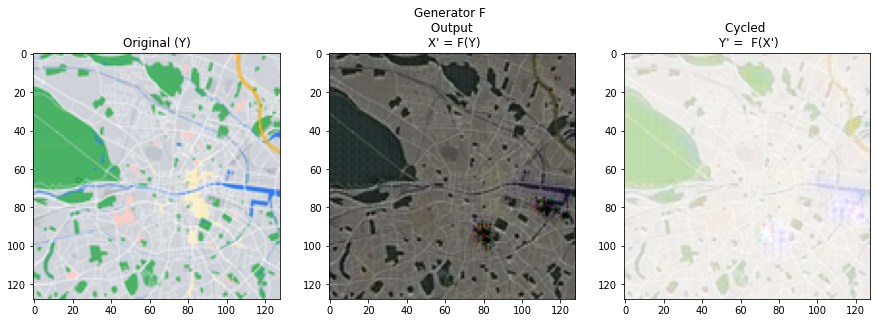

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


average of cycle and identity loss = 0.05958505719900131
 Accuracy = 1 - avg_loss = 0.9404149651527405


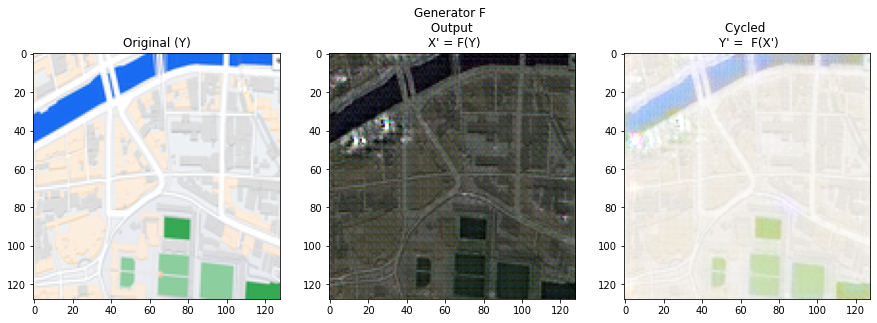

In [88]:
generate_image(normalize(convert_img(path="C:/Users/astro/Documents/MASTER'S Courses/Maynooth uni/Courses/SEM_2/Final project/Aerial-images-to-maps/dublin2 map.png")),a_to_m=False)
generate_image(normalize(convert_img(path="C:/Users/astro/Documents/MASTER'S Courses/Maynooth uni/Courses/SEM_2/Final project/Aerial-images-to-maps/temple bar.png")),a_to_m=False)

In [213]:
convert_img(path="C:/Users/astro/Documents/MASTER'S Courses/Maynooth uni/Courses/SEM_2/Final project/Aerial-images-to-maps/university aerial.png")

255

(array([[ 0., 12., 34., ...,  0.,  0.,  0.],
        [ 1., 11., 30., ...,  0.,  0.,  0.],
        [ 0.,  9., 30., ...,  0.,  0.,  0.],
        ...,
        [ 2., 13., 26., ...,  0.,  0.,  0.],
        [ 2., 14., 39., ...,  0.,  0.,  0.],
        [ 4., 12., 41., ...,  0.,  0.,  0.]]),
 array([  0. ,  25.5,  51. ,  76.5, 102. , 127.5, 153. , 178.5, 204. ,
        229.5, 255. ]),
 <a list of 128 Lists of Patches objects>)

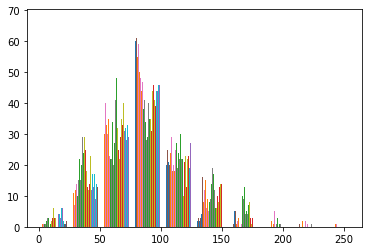

In [76]:
plt.hist(convert_img(path="C:/Users/astro/Documents/MASTER'S Courses/Maynooth uni/Courses/SEM_2/Final project/Aerial-images-to-maps/university aerial.png")[:,:,1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


average of cycle and identity loss = 0.03958665579557419
 Accuracy = 1 - avg_loss = 0.9604133367538452


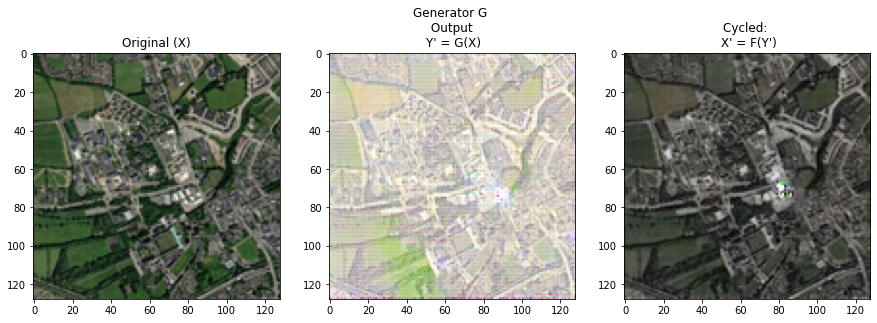

In [67]:
generate_image(normalize(convert_img(path="C:/Users/astro/Documents/MASTER'S Courses/Maynooth uni/Courses/SEM_2/Final project/Aerial-images-to-maps/university aerial.png")),a_to_m=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


average of cycle and identity loss = 0.02147369459271431
 Accuracy = 1 - avg_loss = 0.9785262942314148


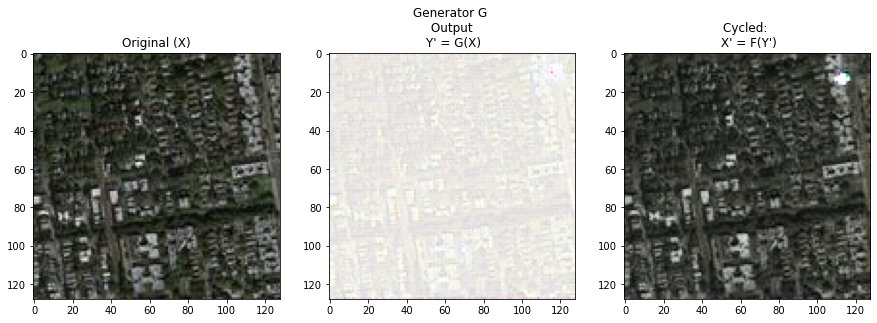

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


average of cycle and identity loss = 0.020352661609649658
 Accuracy = 1 - avg_loss = 0.9796473383903503


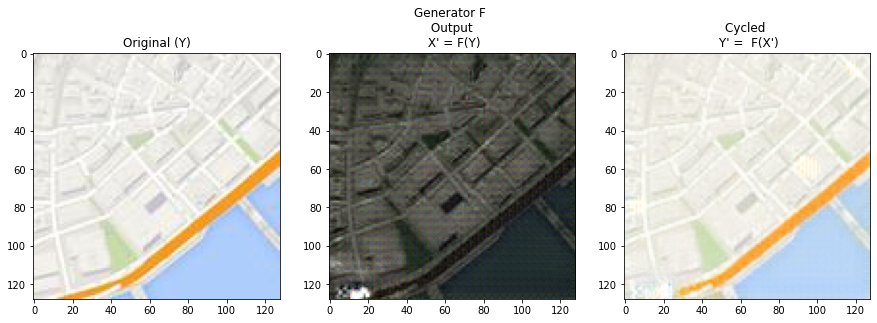

In [226]:
generate_image(test_aerial[149],a_to_m=True)
generate_image(normalize(test_maps[47]),a_to_m=False)

# --------------------------------------------------------------------------

# Kernel Start ------------------------------------------------------------

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time

c:\users\astro\appdata\local\programs\python\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\users\astro\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
c:\users\astro\appdata\local\programs\python\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


###  Re-run class object

In [4]:
class InstanceNormalization(Layer):
    """Instance normalization layer.
    Normalize the activations of the previous layer at each step,
    i.e. applies a transformation that maintains the mean activation
    close to 0 and the activation standard deviation close to 1.
    # Arguments
        axis: Integer, the axis that should be normalized
            (typically the features axis).
            For instance, after a `Conv2D` layer with
            `data_format="channels_first"`,
            set `axis=1` in `InstanceNormalization`.
            Setting `axis=None` will normalize all values in each
            instance of the batch.
            Axis 0 is the batch dimension. `axis` cannot be set to 0 to avoid errors.
        epsilon: Small float added to variance to avoid dividing by zero.
        center: If True, add offset of `beta` to normalized tensor.
            If False, `beta` is ignored.
        scale: If True, multiply by `gamma`.
            If False, `gamma` is not used.
            When the next layer is linear (also e.g. `nn.relu`),
            this can be disabled since the scaling
            will be done by the next layer.
        beta_initializer: Initializer for the beta weight.
        gamma_initializer: Initializer for the gamma weight.
        beta_regularizer: Optional regularizer for the beta weight.
        gamma_regularizer: Optional regularizer for the gamma weight.
        beta_constraint: Optional constraint for the beta weight.
        gamma_constraint: Optional constraint for the gamma weight.
    # Input shape
        Arbitrary. Use the keyword argument `input_shape`
        (tuple of integers, does not include the samples axis)
        when using this layer as the first layer in a Sequential model.
    # Output shape
        Same shape as input.
    # References
        - [Layer Normalization](https://arxiv.org/abs/1607.06450)
        - [Instance Normalization: The Missing Ingredient for Fast Stylization](
        https://arxiv.org/abs/1607.08022)
    """
    def __init__(self,
                 axis=None,
                 epsilon=1e-3,
                 center=True,
                 scale=True,
                 beta_initializer='zeros',
                 gamma_initializer='ones',
                 beta_regularizer=None,
                 gamma_regularizer=None,
                 beta_constraint=None,
                 gamma_constraint=None,
                 **kwargs):
        super(InstanceNormalization, self).__init__(**kwargs)
        self.supports_masking = True
        self.axis = axis
        self.epsilon = epsilon
        self.center = center
        self.scale = scale
        self.beta_initializer = initializers.get(beta_initializer)
        self.gamma_initializer = initializers.get(gamma_initializer)
        self.beta_regularizer = regularizers.get(beta_regularizer)
        self.gamma_regularizer = regularizers.get(gamma_regularizer)
        self.beta_constraint = constraints.get(beta_constraint)
        self.gamma_constraint = constraints.get(gamma_constraint)

    def build(self, input_shape):
        ndim = len(input_shape)
        if self.axis == 0:
            raise ValueError('Axis cannot be zero')

        if (self.axis is not None) and (ndim == 2):
            raise ValueError('Cannot specify axis for rank 1 tensor')

        self.input_spec = InputSpec(ndim=ndim)

        if self.axis is None:
            shape = (1,)
        else:
            shape = (input_shape[self.axis],)

        if self.scale:
            self.gamma = self.add_weight(shape=shape,
                                         name='gamma',
                                         initializer=self.gamma_initializer,
                                         regularizer=self.gamma_regularizer,
                                         constraint=self.gamma_constraint)
        else:
            self.gamma = None
        if self.center:
            self.beta = self.add_weight(shape=shape,
                                        name='beta',
                                        initializer=self.beta_initializer,
                                        regularizer=self.beta_regularizer,
                                        constraint=self.beta_constraint)
        else:
            self.beta = None
        self.built = True

    def call(self, inputs, training=None):
        input_shape = K.int_shape(inputs)
        reduction_axes = list(range(0, len(input_shape)))

        if self.axis is not None:
            del reduction_axes[self.axis]

        del reduction_axes[0]

        mean = K.mean(inputs, reduction_axes, keepdims=True)
        stddev = K.std(inputs, reduction_axes, keepdims=True) + self.epsilon
        normed = (inputs - mean) / stddev

        broadcast_shape = [1] * len(input_shape)
        if self.axis is not None:
            broadcast_shape[self.axis] = input_shape[self.axis]

        if self.scale:
            broadcast_gamma = K.reshape(self.gamma, broadcast_shape)
            normed = normed * broadcast_gamma
        if self.center:
            broadcast_beta = K.reshape(self.beta, broadcast_shape)
            normed = normed + broadcast_beta
        return normed

    def get_config(self):
        config = {
            'axis': self.axis,
            'epsilon': self.epsilon,
            'center': self.center,
            'scale': self.scale,
            'beta_initializer': initializers.serialize(self.beta_initializer),
            'gamma_initializer': initializers.serialize(self.gamma_initializer),
            'beta_regularizer': regularizers.serialize(self.beta_regularizer),
            'gamma_regularizer': regularizers.serialize(self.gamma_regularizer),
            'beta_constraint': constraints.serialize(self.beta_constraint),
            'gamma_constraint': constraints.serialize(self.gamma_constraint)
        }
        base_config = super(InstanceNormalization, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

## Convert image data to arrays

In [9]:
train_aerial_path = './maps/maps/trainA'
train_maps_path = './maps/maps/trainB'
# Number of train images
print(len(os.listdir(train_aerial_path)))
print(len(os.listdir(train_maps_path)))


test_aerial_path = './maps/maps/testA'
test_maps_path = './maps/maps/testB'

print(len(os.listdir(test_aerial_path)))
print(len(os.listdir(test_maps_path)))
train_aerial = []
train_maps = []

# For aerial images
for image_name in os.listdir(train_aerial_path):
    full_img_name = os.path.join(train_aerial_path,image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    train_aerial.append(img_arr/255)
# For maps images
for image_name in os.listdir(train_maps_path):
    full_img_name = os.path.join(train_maps_path, image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    train_maps.append(img_arr/255)

# we can also take few images from test folder for training purposes
# For aerial images
for image_name in os.listdir(test_aerial_path)[:500]:
    full_img_name = os.path.join(test_aerial_path,image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    train_aerial.append(img_arr/255)
# For maps images
for image_name in os.listdir(test_maps_path)[500:1000]:
    full_img_name = os.path.join(test_maps_path, image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    train_maps.append(img_arr/255)
train_aerial = np.array(train_aerial, dtype='float32')
train_maps = np.array(train_maps, dtype = 'float32')
print(train_aerial.shape)
print(train_maps.shape)
test_aerial = []
test_maps = []

# For aerial images
for image_name in os.listdir(test_aerial_path)[500:1000]:
    full_img_name = os.path.join(test_aerial_path,image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    test_aerial.append(img_arr/255)
# For maps images
for image_name in os.listdir(test_maps_path)[:500]:
    full_img_name = os.path.join(test_maps_path, image_name)
    img_arr = plt.imread(full_img_name)
    if img_arr.shape != (128,128,3):
        continue
    # normalizing images from 0 to 1
    test_maps.append(img_arr/255)

test_aerial = np.array(test_aerial, dtype='float32')
test_maps = np.array(test_maps, dtype = 'float32')
print(test_aerial.shape)
print(test_maps.shape)

1096
1096
1098
1098
(1596, 128, 128, 3)
(1596, 128, 128, 3)
(500, 128, 128, 3)
(500, 128, 128, 3)


## Recalling the models:

In [25]:
# recalling the models
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import backend as  K

generator_g = tf.keras.models.load_model('generator_g_better.h5',
                                         custom_objects={'InstanceNormalization':InstanceNormalization})

#### generator_f_better.h5 works better than generator_f_better2.h5 i guess
generator_f = tf.keras.models.load_model('generator_f_better2.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

discriminator_x = tf.keras.models.load_model('discriminator_x_better2.h5',custom_objects={'InstanceNormalization':InstanceNormalization})
discriminator_y = tf.keras.models.load_model('discriminator_y_better2.h5',custom_objects={'InstanceNormalization':InstanceNormalization})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


average of cycle and identity loss = 0.12922388315200806
 Accuracy = 1 - avg_loss = 0.8707761168479919


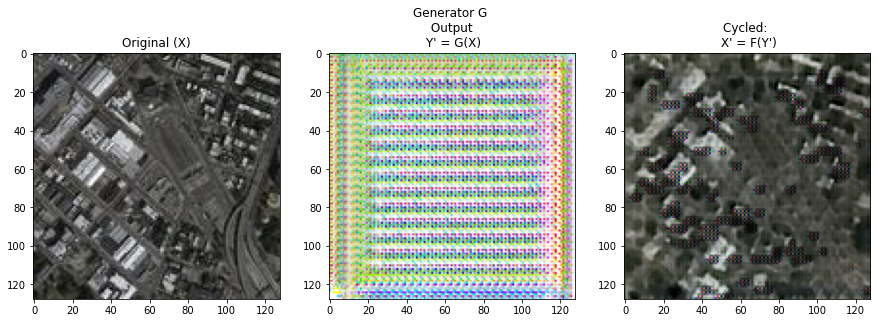

In [44]:
generate_image(inp_img=test_aerial[111])

In [45]:
def eval_cycle_loss(real_image, cycle_image):
    # Update: 01062022 used maxplool layers for losses
    maxpool_real = tf.keras.layers.MaxPooling2D(pool_size=(4,4),
                                                strides=(1,1))(tf.reshape(real_image,(1,128,128,3)))[0] # constant image shape assumption
    maxpool_cycled = tf.keras.layers.MaxPooling2D(pool_size=(4,4),
                                                  strides=(1,1))(tf.reshape(cycle_image,(1,128,128,3)))[0]

    loss_maxpool = tf.reduce_mean(tf.abs(maxpool_real-maxpool_cycled))
    #loss1 = tf.reduce_mean(tf.abs(real_image-cycle_image))
    return loss_maxpool

''' generator_g is responsible for translating image X to image Y. Identity
loss says that, if you fed image Y to generator G, it should yield the real
image Y or something close to image Y.
    identity_loss = |G(Y)-Y|+|F(X)-X|'''

def eval_identity_loss(real_image, same_image):
    # Update: 01062022 used maxplool layers for losses
    maxpool_real = tf.keras.layers.MaxPooling2D(pool_size=(4,4),
                                                strides=(1,1))(tf.reshape(real_image,(1,128,128,3)))[0]
    maxpool_same = tf.keras.layers.MaxPooling2D(pool_size=(4,4),
                                                strides=(1,1))(tf.reshape(same_image,(1,128,128,3)))[0]
    loss = tf.reduce_mean(tf.abs(maxpool_real - maxpool_same))
    return loss

In [ ]:
import time
import pyautogui as pag

hours = 20
for i in range(hours):
    print(f"{i} hours done...")
    time.sleep(60*60)
    if i % 2 == 0:
        pag.press('left')
    else:
        pag.press('right')

0 hours done...
1 hours done...
2 hours done...
3 hours done...
4 hours done...
5 hours done...
6 hours done...
7 hours done...


In [95]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [96]:
np.random.randint(0,10,100)

array([7, 7, 8, 7, 0, 4, 8, 6, 0, 4, 0, 3, 0, 2, 5, 9, 0, 3, 1, 3, 6, 1,
       7, 0, 5, 4, 4, 6, 8, 6, 7, 9, 8, 4, 5, 5, 7, 9, 3, 6, 4, 4, 9, 1,
       9, 9, 2, 7, 1, 2, 8, 8, 2, 4, 4, 8, 0, 3, 4, 5, 3, 0, 0, 1, 3, 5,
       2, 6, 4, 8, 9, 3, 1, 7, 0, 2, 9, 6, 6, 5, 7, 1, 0, 6, 5, 2, 8, 3,
       0, 9, 8, 4, 7, 5, 6, 9, 7, 9, 6, 2])

In [103]:
df = pd.DataFrame({'D': np.random.uniform(-78,-65, 100),
                  'RA': np.random.uniform(0,50,100)})

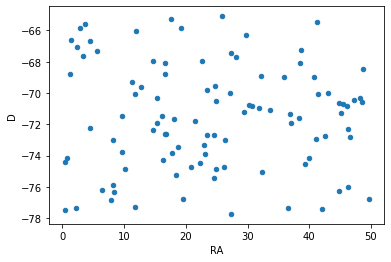

In [104]:
df.plot.scatter('RA',"D")

In [108]:
bruh = np.arange(0,10)

(bruh.max() - bruh.min())/5

1.8

In [111]:
bruh.max()

9

In [109]:
1.8*5

9.0

In [115]:
df['RA'].values

array([16.16913729, 27.35640141, 16.56374902, 12.72002795,  7.84986157,
        8.25667479, 10.12228439,  4.45165148, 21.51619382, 28.1694315 ,
       49.67282183, 45.4796278 , 45.09813575, 44.82308373, 41.04785347,
       14.64746443, 24.8322879 , 22.36424514, 29.40663587, 30.77151572,
       16.6879417 , 30.24896965, 48.49933456, 22.92706318, 18.41439003,
       24.64518239, 46.22590454, 26.22207799, 20.80892736,  6.49206369,
       26.36467641, 15.36534215,  3.63866947, 25.81764481, 43.01342399,
       35.91630156,  0.40231515, 41.27300824,  1.15882016, 31.80758874,
       38.45069353,  0.34648868, 11.73893441, 40.0066316 , 19.60532976,
        8.43418497,  2.29290943, 18.76371232, 23.05149531, 46.28532551,
       46.59463015,  5.61603739, 24.90853929, 18.02645668, 22.62377055,
       38.32345339,  4.43696764, 40.75086702, 29.76799349, 27.27015032,
        9.73018242, 42.03308478, 36.55497055, 38.72403576, 36.81107489,
        9.68018194, 41.36234077, 27.22873371, 42.47981254, 15.39

In [112]:
for i in range(5):
    print((i+1)*1.8)

1.8
3.6
5.4
7.2
9.0


In [149]:
5%5

0

In [150]:
d = [df,df]

In [152]:
d[0]

D         RA
0  -71.479019  16.169137
1  -77.727981  27.356401
2  -72.631279  16.563749
3  -69.615141  12.720028
4  -76.812442   7.849862
..        ...        ...
95 -69.830405  23.456500
96 -75.021339  32.277784
97 -66.624071   1.390503
98 -74.135128   0.669810
99 -65.863791   2.811743

[100 rows x 2 columns]

In [158]:
def split(df, x,y, n_split = 5, x_name = 'RA', y_name= 'D'):
    """
    x = df['RA'] # right ascension
    y = df['D'] # declination
    
    n_split = number of splits"""
    
    
    # for x
    len_x = x.values.max() - x.values.min()
    
    # for y
    len_y = y.values.max() - y.values.min()
    
    # intervals
    x_interval = len_x/n_split
    y_interval = len_y/n_split
    
    # interval stops
    x_stops = []
    y_stops = []
    
    for i in range(n_split):
        x_stops.append(x.values.min() + (i+1)*x_interval)
        y_stops.append(y.values.min() + (i+1)*y_interval)
    
    dfs = []
    
    for i in range(n_split):
        for j in range(n_split):
            dfs.append(df[(df[x_name]>(x_stops[i]-x_interval)) & (df[x_name]<x_stops[i]) & (df[y_name]>(y_stops[j] - y_interval)) & (df[y_name]<y_stops[j])])
    return dfs

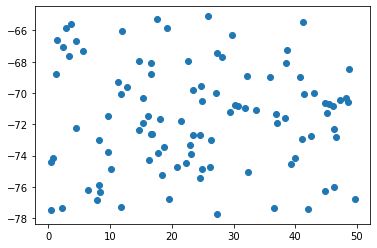

In [162]:
plt.scatter(df['RA'],df['D'])
plt.scatter(dfs[])

In [159]:
dfs = split(df, df['RA'],df['D'],n_split=5)

In [161]:
len(dfs)

25

In [143]:
a,b = split(x=df['RA'], y=df['D'],n_split=5)

In [144]:
print(a,b)

[10.21175530721952, 20.0770219385135, 29.94228856980748, 39.80755520110146, 49.672821832395435] [-75.20036068941766, -72.67274028391317, -70.14511987840869, -67.6174994729042, -65.08987906739972]


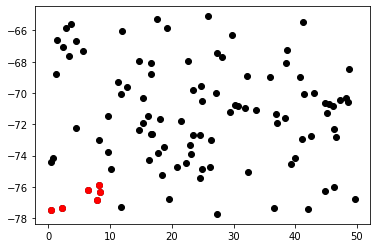

In [165]:
# plt.scatter(a,b)
plt.scatter(df['RA'],df['D'],color='black')
plt.scatter(dfs[0]['RA'],dfs[0]['D'],color='red')

In [216]:
df = pd.DataFrame({"Star Magnitude":[1,4],'Sky Magnitude':[4,7], 'label':[3,4]})

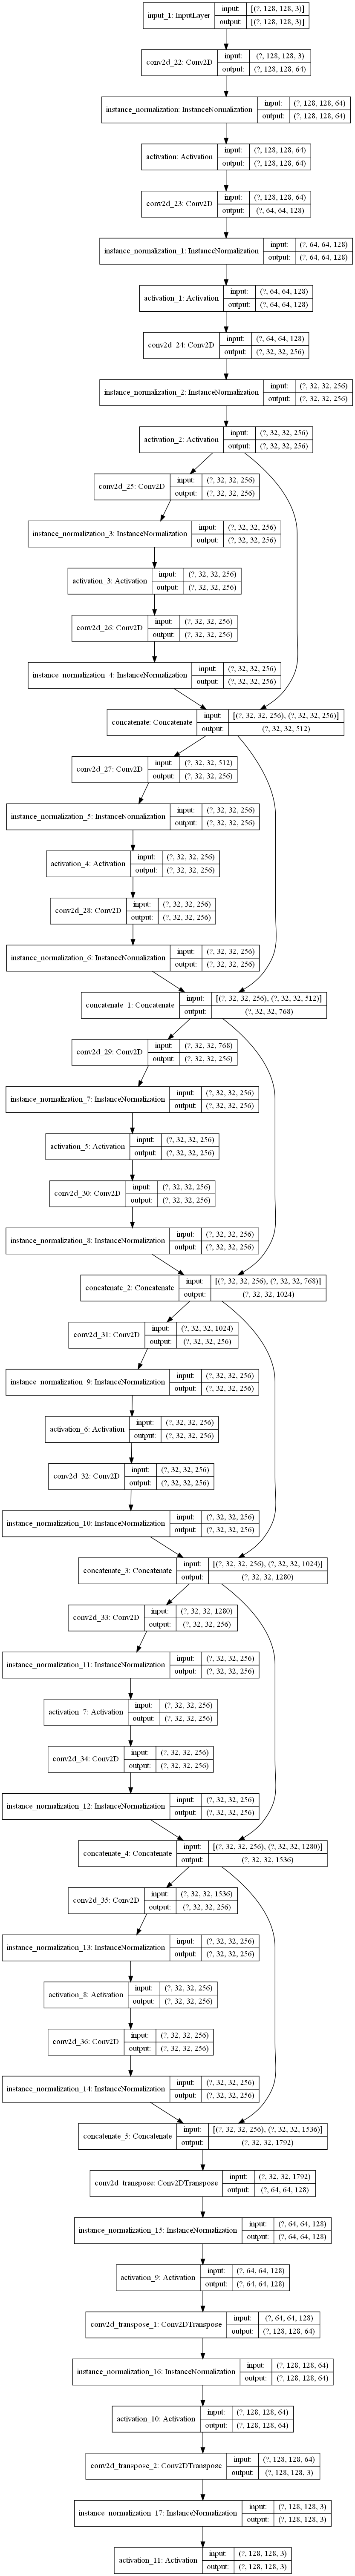

In [102]:
tf.keras.utils.plot_model(generator_g,show_shapes=True,to_file='./generator_g architecture.png',expand_nested=)

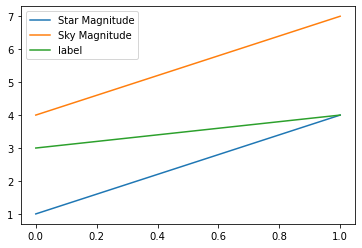

In [92]:
def hist_img(image, show_hist=False):
    fig, axs = plt.subplots(1,2,figsize=(10,5))
    axs[0].imshow(image)
    sns.kdeplot(image[:,:,0].flatten(),color='red',shade=True,ax=axs[1])
    sns.kdeplot(image[:,:,1].flatten(),color='green',shade=True,ax=axs[1])
    sns.kdeplot(image[:,:,2].flatten(),color='blue',shade=True,ax=axs[1])
    #plt.title('Color Composition')

In [93]:
import seaborn as sns

In [94]:
maynooth_a = convert_img(path="C:/Users/astro/Documents/MASTER'S Courses/Maynooth uni/Courses/SEM_2/Final project/Aerial-images-to-maps/university aerial.png")

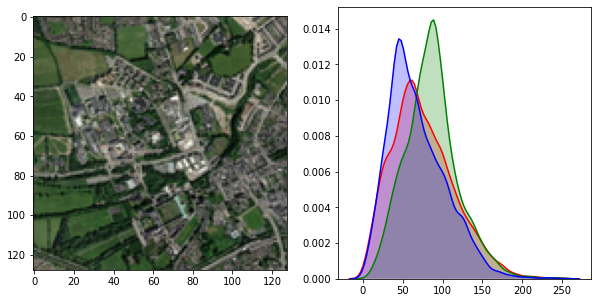

In [95]:
hist_img(maynooth_a)